# GOES autocorrelation analysis


[Autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) analysis considers the statistical dependence between elements of a time series in terms of the amount of elapsed time between them.

The usual measure of time series autocorrelation is based on Pearson correlation.  But for time series with potentially heavy-tailed marginal distributions, a robust form of autocorrelation analysis can be conducted using the [Kendall tau](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient) autocorrelation.  Specifically, we can consider the [Kendall tau autocorrelation](https://escholarship.org/uc/item/7jt8s827) at lag $s$, between the series $X(t)$ and the shifted series $X(t+s)$.

An important point of consideration in any time series analysis is whether the time series is [stationary](https://en.wikipedia.org/wiki/Stationary_process).  If the time series is not stationary, it is difficult to interpret the autocorrelation function. 

The GOES series are very long (one year of data at a 2-second cadence gives over 14 million observations), and it is unlikely that they are stationary (for example, there is an 11 year cycle and any given year occupies a limited subinterval of this cycle).  To address this, we can consider blocks of consecutive observations taken from the much longer X-ray flux time series, and estimate the autocorrelation function for each block.  Below we consider blocks of around 4 hours in duration, consisting of around 8000 serial observations. The block size can be set below via the variable 'bs'.

This analysis is informative about local dependence within each block, as well as about the extent of non-stationarity in the full (year-long) time series.

In [1]:
import numpy as np
from read import *
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import scipy.stats as stats
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
df = get_goes(2017)
df.head()

,Flux1,Flux2,Time
1,1.517700e-07,1.000000e-09,2017-01-01 00:00:01.931999922
2,1.517700e-07,1.296400e-09,2017-01-01 00:00:03.978999853
3,1.483700e-07,5.117400e-09,2017-01-01 00:00:06.028999805
4,1.500700e-07,1.296400e-09,2017-01-01 00:00:08.074999809
5,1.534600e-07,2.934000e-09,2017-01-01 00:00:10.125000000


Set the block size.  If bs=8000 the overall time of each block is around 4.4 hours.

In [27]:
bs = 8000
2*bs / (60 * 60) # the number of hours in a block

4.444444444444445

The standard error of Kendall's tau for iid data.

In [4]:
tse = np.sqrt(2 * (2 * bs + 5) / (9 * bs * (bs - 1)))

Make blocks of 'bs' consecutive time points with approximately 2-second spacing.

In [5]:
tix, flx = make_blocks(df, bs, 0)

In [24]:
n, p = flx.shape

(1193, 8000)

Consider autocorrelation at these time lags

In [7]:
dlags = np.arange(1, 200, 10)

Convert lags to time in minutes

In [8]:
dtime = dlags * 2 / 60

Calculate these quantiles across blocks of the autocorrelations.

In [9]:
pr = [0.25, 0.5, 0.75]

Get the autocorrelation for each block

In [10]:
qd = np.zeros((n, len(dlags)))
for (j,d) in enumerate(dlags):
    for i in range(flx.shape[0]):
        qd[i, j] = stats.kendalltau(flx[i, 0:p-d], flx[i, d:]).correlation

Below is a spaghetti plot of a random subset of the block-wise autocorrelation functions.

Text(0, 0.5, 'Tau autocorrelation')

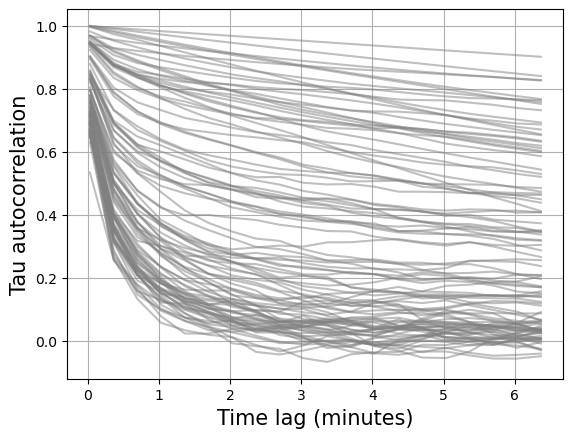

In [30]:
plt.grid(True)
ii = np.random.choice(qd.shape[0], 100, replace=False)
for i in ii:
    plt.plot(dtime, qd[i, :], "-", color="grey", alpha=0.5)
plt.xlabel("Time lag (minutes)", size=15)
plt.ylabel("Tau autocorrelation", size=15)

Plot some quantiles of the autocorrelation functions.

Text(0, 0.5, 'Tau autocorrelation quantile')

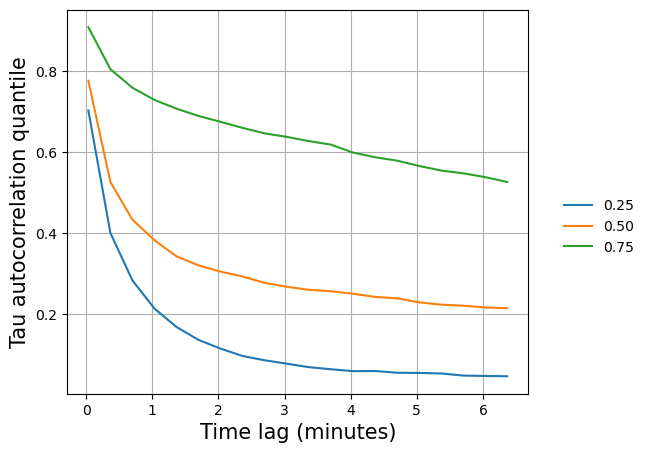

In [18]:
plt.axes([0.1, 0.1, 0.72, 0.8])
plt.grid(True)
for i, p in enumerate(pr):
    qq = np.quantile(qd, p, axis=0)
    plt.plot(dtime, qq, label="%.2f" % p)
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, loc="center right")
leg.draw_frame(False)
plt.xlabel("Time lag (minutes)", size=15)
plt.ylabel("Tau autocorrelation quantile", size=15)

PC decompose the estimated autcorrelation functions

In [36]:
qdm = qd.mean(0)
qdc = qd - qdm
u, s, vt = np.linalg.svd(qdc, 0)
v = vt.T
scores = np.dot(u, np.diag(s))

A basic analysis of the spectrum:

Text(0, 0.5, 'Log singular value')

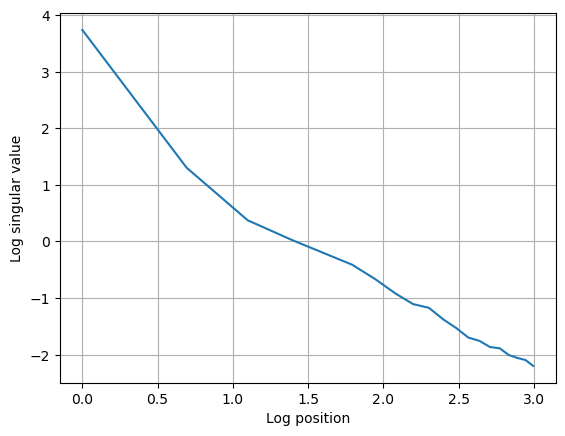

In [37]:
plt.grid(True)
pp = np.arange(1, len(qdm)+1)
plt.plot(np.log(pp), np.log(s))
plt.xlabel("Log position")
plt.ylabel("Log singular value")

Plot the mean autocorrelation +/- each PC.

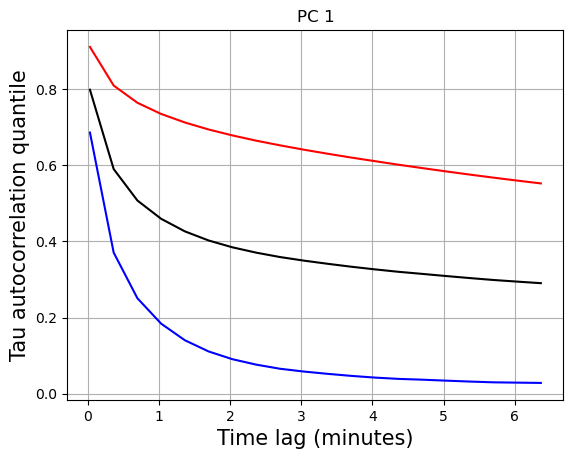

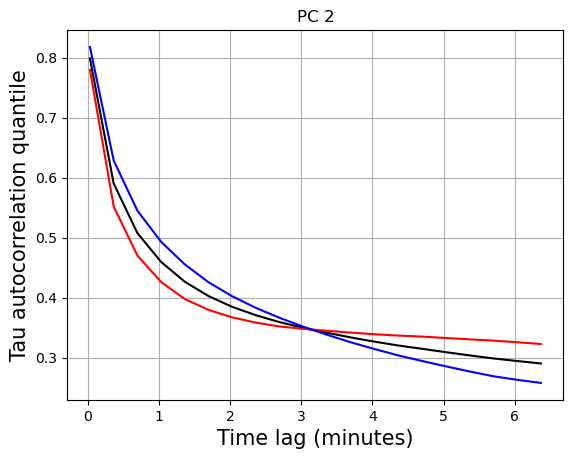

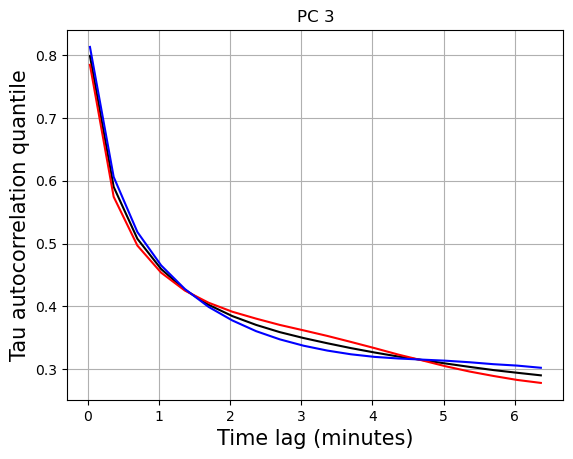

In [19]:
for j in range(3):
    plt.clf()
    plt.grid(True)
    plt.title("PC %d" % (j + 1))
    sd = scores[:, j].std(0)
    plt.plot(dtime, qdm, '-', color="black")
    plt.plot(dtime, qdm + sd*v[:, j], '-', color="red")
    plt.plot(dtime, qdm - sd*v[:, j], '-', color="blue")
    plt.xlabel("Time lag (minutes)", size=15)
    plt.ylabel("Tau autocorrelation quantile", size=15)
    plt.show()

Plot the PC scores for each factor

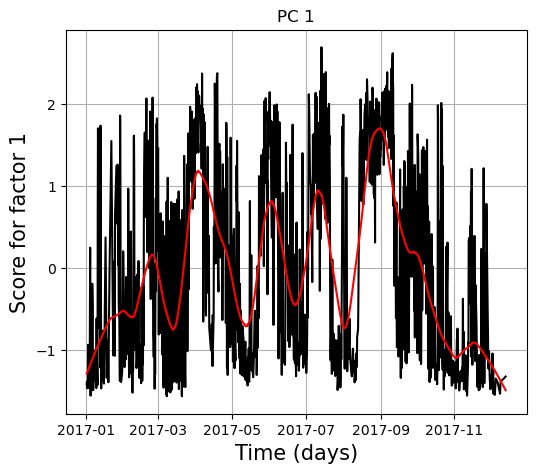

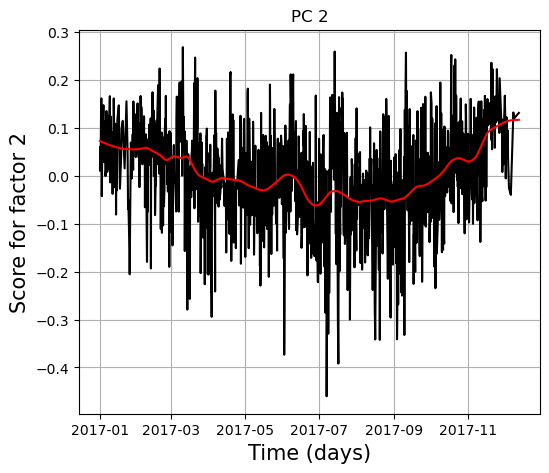

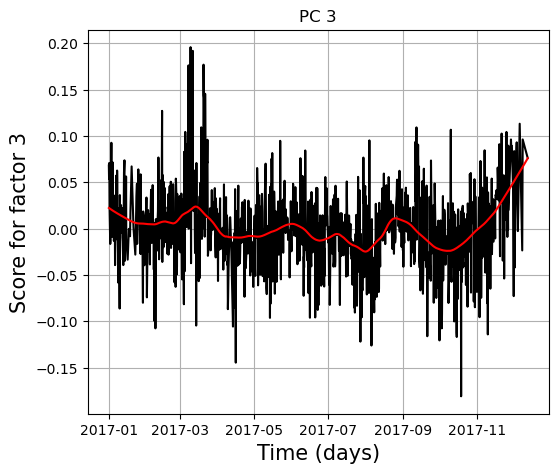

In [23]:
for j in range(3):
    yh = lowess(scores[:, j], tix[:, 0], frac=0.1)
    plt.clf()
    plt.axes([0.15, 0.1, 0.72, 0.8])
    plt.grid(True)
    plt.title("PC %d" % (j + 1))
    plt.plot(tix[:, 0], scores[:, j], '-', color="black")
    plt.plot(tix[:, 0], yh[:, 1], '-', color="red")
    plt.xlabel("Time", size=15)
    plt.ylabel("Score for factor %d" % (j + 1), size=15)
    plt.show()